<a href="https://colab.research.google.com/github/clint-bg/Principles/blob/main/aiaaSafeSitingProposal/safeDistancesOpenBurnplus.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Heat Flux from Propellants and Fireworks
***
## Approach: Estimate the safe distance from test data
This notebook treats the heat flux and its estimation based on open burning of propellant in drums or in fires. Confined scenarios or explosions are not treated hear. Clint Guymon
***
## Conclusions: The safe distance is adequately captured by the existing HD1.3 siting distance for unconfined scenarios.

***
## Necessary code and data import

In [1]:
#Import necessary packages
#%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sea; #sea.set_palette(sea.color_palette("Set2")) #"Paired" "cubehelix"
from scipy.optimize import fsolve, minimize
from scipy.stats import t #import t distribution methods

### Import data

The majority of the heat flux data is from "Scaling Studies of Thermal Radiation Flux from Burning Propellants" by J. Hay and R.W. Watson of Bureau of Mines as commissioned by the DDESB in 1992. Various propellant types and masses were tested in a top down burn or external fire of a single barrel or package of propellant.

In [2]:
url = 'https://raw.githubusercontent.com/clint-bg/publicationdata/main/aiaaSafeSitingProposal/heatfluxdataplus.csv' #url with raw data
df = pd.read_csv(url); df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

In [3]:
df.columns

Index(['Ref ID', 'Reference', 'Propellant type', 'Test #', 'Mass (kg)',
       'Measurement Distance (m)', 'Burn time (sec)', 'Peak flux (cal/cm^2/s)',
       'Av. flux (cal/cm^2/s)', 'Notes', 'Drum diameter (cm)', 'Type'],
      dtype='object')

In [4]:
#add new column for unique id = ref id + test id
df['Unique ID'] = df.agg('R{0[Ref ID]}T{0[Test #]}'.format, axis=1)

## Data summary

In [5]:
summary = df.groupby('Ref ID')['Reference'].unique().to_frame()
summary['Propellant types'] = df.groupby('Ref ID')['Propellant type'].unique()
summary['# of Tests'] = df.groupby('Ref ID')['Test #'].nunique()
summary

,Reference,Propellant types,# of Tests
Ref ID,,,
1,"[DDESB BOM ""SCALING STUDIES OF THERMAL RADIATI...","[IMR5010, M1-8-SP, M1-8-MP, WC844, WC846, WCBl...",49
2,"[TNO T 1022 ""Thermal Radiation of Fireworks"" 1...",[Fireworks],16
3,[DDESB IIT Research Institute R. Pape T. Water...,"[M1, WC844]",46
4,"[SMS C. Guymon ""Heat flux from the Top Ignitio...",[WC814],1
5,[China Lake Ranges Test Operation Branch (DB11...,[M1],1
6,"[ ""China Lake; Convective Combustion of Unconf...",[M1],2
7,"[Blankenhagel, et al., ""Thermal radiation asse...","[di-tert-butyl peroxide, nan]",3
8,"[Williams and Dunne, ""Heat Flux Measurement fr...","[MTV, nan]",12
MSIAC 1,"[Trinkler, ""Thermal Effects in Relation to Amm...",[Cordite],8


In [6]:
#References
for i,each in enumerate(set(df['Reference'])):
    print(i,":",each) 

0 : Wyssen, "Abbrandversuche mit Treibladungspulver in Mengen von 10 bis 1000 kg", Gruppe für Rüstungsdienste / Tecnische Abteilung 6, Feb 1982
1 : Lucotte, "Measurement and prediction of heat flux in gun propellant fires", Proceedings of the 20th DOD
Safety Seminar, 1982
2 : Wyssen, "Thermische Wirkgrössen bei Pulverabbränden", Gruppe für Rüstungdienste / Technische Abteilung 6, Jan 1983
3 : China Lake Ranges Test Operation Branch (DB1110M), "Convective Combustion of a Hazard Division 1.3 M1 Gun Propellant in Fiber Barrels Heat Flux Data, 20 March 2020
4 : Trinkler, "Thermal Effects in Relation to Ammunition Storage", 1958
5 : Williams and Dunne, "Heat Flux Measurement from Bulk Magnesium/Teflon/Viton (MTV) Flare Composition Combustion", Propellants, Explosives, and Pyrotechnics
6 : DDESB IIT Research Institute R. Pape T. Waterman A. Takata "Fire Hazards from Combustible Ammunition, Methodology Development (Phase I)" 1980
7 : Brönnimann, "Thermische Strahlunsdichte beim Abbrand von Tr

In [7]:
#propellant types
set(df['Propellant type'])

{'"hunting powder"',
 '20 mm powder',
 '35mm propellant',
 'Cordite',
 'DB1',
 'DB2',
 'Fireworks',
 'GP11',
 'IMR5010',
 'LB.7T.72 gun propellant (similar to M1)',
 'M1',
 'M1-8-MP',
 'M1-8-SP',
 'MTV',
 'NC powder / cannon propellant mix',
 'NC tubular powder',
 'SB1',
 'SB2',
 'WC814',
 'WC844',
 'WC846',
 'WCBlank',
 'di-tert-butyl peroxide',
 nan}

In [8]:
#number of tests for each propellant
df.groupby('Propellant type')['Test #'].nunique(), df.groupby('Propellant type')['Test #'].nunique().sum()

(Propellant type
 "hunting powder"                            1
 20 mm powder                                6
 35mm propellant                            15
 Cordite                                     8
 DB1                                         4
 DB2                                         2
 Fireworks                                  16
 GP11                                        2
 IMR5010                                    13
 LB.7T.72 gun propellant (similar to M1)     2
 M1                                         26
 M1-8-MP                                    12
 M1-8-SP                                    14
 MTV                                         1
 NC powder / cannon propellant mix           1
 NC tubular powder                           1
 SB1                                         5
 SB2                                         5
 WC814                                       1
 WC844                                      27
 WC846                                     

In [9]:
#total number of heat flux measurements
len(df)

761

In [10]:
df.describe() #summary statistics for numerical data

,Mass (kg),Measurement Distance (m),Burn time (sec),Peak flux (cal/cm^2/s),Av. flux (cal/cm^2/s),Drum diameter (cm)
count,761.000000,761.000000,725.000000,761.000000,761.000000,154.000000
mean,443.842825,7.746386,28.086759,4.009580,1.561985,59.376623
std,1875.039783,6.515022,30.398639,8.173514,3.096214,3.829841
min,0.100000,0.100000,0.400000,0.001505,0.000579,36.000000
25%,25.000000,3.000000,5.400000,0.190800,0.075000,60.000000
50%,50.000000,5.000000,19.000000,0.612000,0.254757,60.000000
75%,136.100000,10.000000,42.000000,3.085443,1.315978,60.000000
max,18000.000000,40.000000,215.000000,65.553588,24.737203,60.000000


In [11]:
df.head(3) #first 3 rows of the data frame

,Ref ID,Reference,Propellant type,Test #,Mass (kg),Measurement Distance (m),Burn time (sec),Peak flux (cal/cm^2/s),Av. flux (cal/cm^2/s),Notes,Drum diameter (cm),Type,Unique ID
0,1,"DDESB BOM ""SCALING STUDIES OF THERMAL RADIATIO...",IMR5010,1,45.4,8.0,35.0,0.468,0.127,Barrel,60.0,Unconfined Burn (Test Data),R1T1
1,1,"DDESB BOM ""SCALING STUDIES OF THERMAL RADIATIO...",IMR5010,1,45.4,6.4,35.0,0.576,0.161,Barrel,60.0,Unconfined Burn (Test Data),R1T1
2,1,"DDESB BOM ""SCALING STUDIES OF THERMAL RADIATIO...",IMR5010,1,45.4,5.0,35.0,1.068,0.289,Barrel,60.0,Unconfined Burn (Test Data),R1T1


## Plot of the Safe Heat Flux vs. Exposure Time

Safe heat flux is per 6055.09, 2012, V1.E9.3.1.2 to prevent second degree burns. with the included limit that after a duration of 20 seconds, the allowable heat flux remains constant at with increasing exposure time. 

In [12]:
#define a safe heat flux as a function of distance per second degree burns and a max exposure time of 20 seconds
#(per 6055.09, 2012, V1.E9.3.1.2 to prevent second degree burns)
qsafeat20 = 0.116 #qsafe at 20 second exposure
def safeHF(t):
    return (t/0.858)**(-1/1.46) if t<20 else qsafeat20

In [13]:
#add column for safe heat flux 
safeQ = df.groupby('Unique ID').apply(lambda x: np.percentile(
    [safeHF(x) for x in x['Burn time (sec)']],75))
safeQ.name = 'Safe Heat Flux (cal/cm2/sec)'
#add to dataframe
df['Safe Heat Flux (cal/cm2/sec)'] = df['Unique ID'].apply(lambda x:safeQ.loc[x])

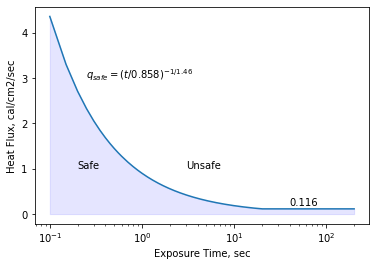

In [14]:
fig, ax = plt.subplots(1,1,figsize=(6,4))
x = np.arange(.1,200,0.05); y=[safeHF(x) for x in x]; 
ax.set_xscale('log');
plt.plot(x,y);
ax.fill_between(x,y,color="blue", alpha=0.1)
plt.text(0.2, 1, 'Safe');plt.text(3, 1, 'Unsafe');plt.text(40, 0.2, '0.116') #, bbox=dict(facecolor='red', alpha=0.5))
plt.text(.25,3,'$q_{safe}=(t/0.858)^{-1/1.46}$')
plt.xlabel('Exposure Time, sec');plt.ylabel('Heat Flux, cal/cm2/sec')
plt.show(block=False)

Here, burn time is equated to the exposure time. After 20 seconds the allowed heat flux is constant at 0.116 cal/cm2/s

### Calculate a safe distance based on the point source model

Calculate a safe distance based on the average heat flux. The average heat flux is used instead of the peak heat flux as the peak heat flux is a short term event and is a small fraction of the total burn typically. The parameters of a Point Source Model are found according to the following where $r^2$ is the squared distance from the center of the fire: 
\begin{equation}
q = \frac{\alpha}{r^2} \\
\end{equation}

In [15]:
#completed for each test (unique id)
alphas = df.groupby('Unique ID').apply(lambda x: np.percentile(
    x['Av. flux (cal/cm^2/s)']*x['Measurement Distance (m)']**2,75))
#alphas = [1 if each < 1 else each for each in alphas]
safeDistance = np.sqrt(alphas/safeQ)
safeDistance = pd.Series(safeDistance)
safeDistance.name = 'Safe Distance (m)'
safeDistance.index = safeQ.index

In [16]:
#add column for safe distance
df['Safe Distance (m)'] =  df['Unique ID'].apply(lambda x:safeDistance.loc[x])
#add column for burn rate
burnRate = df.groupby('Unique ID').apply(lambda x: np.percentile(x['Mass (kg)']/x['Burn time (sec)'],50))
burnRate.name = 'Burn rate (kg/s)'
df['Burn rate (kg/s)'] =  df['Unique ID'].apply(lambda x:burnRate.loc[x])

In [17]:
safeDistance = pd.DataFrame(safeDistance)
safeDistance['Propellant type'] = df.groupby('Unique ID').apply(lambda x: x['Propellant type'].iloc[0])
safeDistance['Mass (kg)'] = df.groupby('Unique ID').apply(lambda x: x['Mass (kg)'].iloc[0])
safeDistance['Safe Heat Flux (cal/cm2/sec)'] = df.groupby('Unique ID').apply(lambda x: x['Safe Heat Flux (cal/cm2/sec)'].iloc[0])
safeDistance['alphas'] = alphas

In [18]:
safeDistance[safeDistance['Propellant type']=='M1-8-MP']

,Safe Distance (m),Propellant type,Mass (kg),Safe Heat Flux (cal/cm2/sec),alphas
Unique ID,,,,,
R1T12,7.974583,M1-8-MP,47.6,0.199918,12.71360
R1T16,11.077484,M1-8-MP,47.6,0.155406,19.07000
R1T17,9.998706,M1-8-MP,47.6,0.164164,16.41216
R1T24,14.137273,M1-8-MP,95.3,0.140897,28.16000
R1T25,14.661709,M1-8-MP,95.3,0.140897,30.28800
R1T3,8.683471,M1-8-MP,47.6,0.140897,10.62400
R1T30,15.398794,M1-8-MP,190.5,0.116000,27.50625
R1T33,10.339499,M1-8-MP,47.6,0.164164,17.55000
R1T36,15.425773,M1-8-MP,142.9,0.117722,28.01250


In [20]:
#example analysis result for Safe Distance given test results
df[df['Unique ID']=='RMSIAC 6TC4']#['Av. flux (cal/cm^2/s)']

,Ref ID,Reference,Propellant type,Test #,Mass (kg),Measurement Distance (m),Burn time (sec),Peak flux (cal/cm^2/s),Av. flux (cal/cm^2/s),Notes,Drum diameter (cm),Type,Unique ID,Safe Heat Flux (cal/cm2/sec),Safe Distance (m),Burn rate (kg/s)
706,MSIAC 6,"Paquet et al., ""Modeling Propellant Fires Radi...",DB1,C4,525.0,20.0,7.1,1.105804,0.552902,Ave heat flux is estimated from the peak heat ...,NaN,? Burn (Test Data),RMSIAC 6TC4,0.235174,34.445076,73.943662
707,MSIAC 6,"Paquet et al., ""Modeling Propellant Fires Radi...",DB1,C4,525.0,16.0,7.1,2.631956,1.315978,Ave heat flux is estimated from the peak heat ...,NaN,? Burn (Test Data),RMSIAC 6TC4,0.235174,34.445076,73.943662
708,MSIAC 6,"Paquet et al., ""Modeling Propellant Fires Radi...",DB1,C4,525.0,8.0,7.1,5.201815,2.600908,Ave heat flux is estimated from the peak heat ...,NaN,? Burn (Test Data),RMSIAC 6TC4,0.235174,34.445076,73.943662


In [30]:
mlin = np.linspace(1,100000,num=500)
ibd = [max(22.9,np.exp(1.4715+0.2429*np.log(each)+0.00384*(np.log(each))**2)) if each<43544 else np.exp(5.5938-0.5344*np.log(each)+0.04046*(np.log(each))**2) for each in mlin]
ibd = pd.DataFrame({'masses (kg)':mlin,'ibd (m)':ibd})
natoibd = pd.DataFrame({'NEQ (kg)':[1,	5,	10,	50,	100,	453,	500,	800,	1000,	5000,	10000,	43544,	500000,	1000000],'ibd (m)':[60,	60,	60,	60,	60,	60,	60,	60,	64,	109,	137,	225,	507,	640]})

## Add modeling results from COMSOL with Radiation in Participating Media
COMSOL modeling was completed with a representative barrel of burning material at a given burn rate and temperature with radiative propagation from the hot gases.

In [31]:
url='https://raw.githubusercontent.com/clint-bg/publicationdata/main/aiaaSafeSitingProposal/COMSOLModeling.csv'
dfm = pd.read_csv(url)
dft = pd.concat([df,dfm])

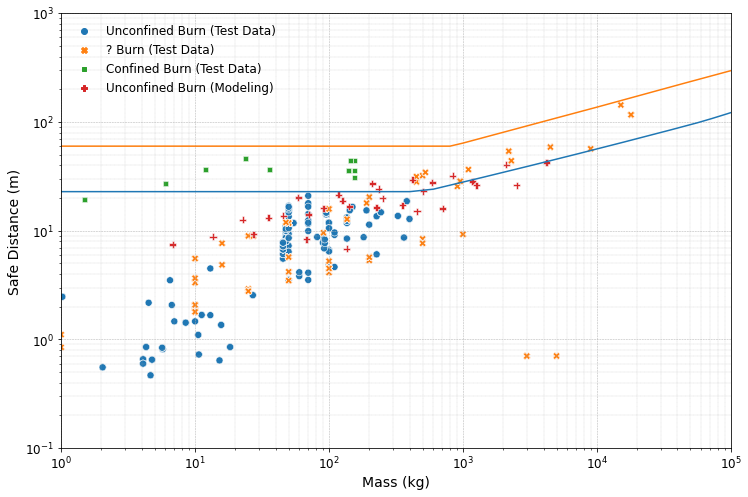

In [32]:
fig, ax = plt.subplots(figsize=(12,8))
p = sea.scatterplot(data=dft,x='Mass (kg)',y='Safe Distance (m)', style='Type', hue='Type',s=50,ax=ax);
p = sea.lineplot(data=ibd,x='masses (kg)',y='ibd (m)',ax=ax)
p = sea.lineplot(data=natoibd,x='NEQ (kg)',y='ibd (m)',ax=ax)
p.set(xscale="log"); p.set(xlim=(1,100000))
p.set(yscale="log"); p.set(ylim=(0.1,1000))
plt.legend(loc='best', fontsize=12, frameon=False)
plt.grid(linestyle = '--', linewidth = 0.5)
plt.grid(visible=True,which='minor',linestyle = '--', linewidth = 0.25)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_xlabel('Mass (kg)', fontsize=14)
ax.set_ylabel('Safe Distance (m)', fontsize=14)
#plt.savefig("SafeDistUn.png",dpi=600)
plt.show()

Note that there are many different ways that a safe distance could be estimated. The method used here is viewed by the authors as a conservative estimate. In previous plots, a modified version of the point source model with a 1/r dependence transitioning to a 1/r^2 dependence was used yielding slightly different results but with the same conclusion that the existing IBD line is effective in specifying a safe distance.